# Groundwater

## Objectives

- Estimate baseflow using a digital pass recursive filter

- Compute the baseflow index

- Use an interpretable machine learning approach to determine the main catchment characteristics which influence the baseflow index 

We will start by loading the CAMELS data that we have used previously:

In [ ]:
import os
from pathlib import Path

SHARED_DATADIR = Path(os.environ["SHARED_DATA_DIR"])
DATADIR = SHARED_DATADIR / '8344e4f3-d2ea-44f5-8afa-86d2987543a9' / 'data'

In [210]:
import pandas as pd
id = '10002'
data = pd.read_csv(os.path.join(DATADIR, 'timeseries', f'CAMELS_GB_hydromet_timeseries_{id}_19701001-20150930.csv'), parse_dates=[0])
data['id'] = id
data.head()

,date,precipitation,pet,temperature,discharge_spec,discharge_vol,peti,humidity,shortwave_rad,longwave_rad,windspeed,id
0,1970-10-01,4.67,1.15,9.38,NaN,NaN,1.43,6.05,71.60,323.22,7.38,10002
1,1970-10-02,1.70,1.41,8.27,NaN,NaN,1.76,5.45,115.58,287.59,10.39,10002
2,1970-10-03,4.28,1.27,9.17,NaN,NaN,1.52,5.56,76.19,315.95,5.92,10002
3,1970-10-04,2.41,0.62,10.75,NaN,NaN,0.82,7.40,45.54,345.59,6.39,10002
4,1970-10-05,0.02,1.44,10.39,NaN,NaN,1.48,6.21,109.42,298.20,7.96,10002


We are going to apply a *digital pass recursive filter* to estimate baseflow from discharge timeseries data. The filter can be expressed: 

$q_{t} = Q_{t} - \left(\beta q_{t-1} + \frac{1 + \beta}{2}\cdot(Q_{t} - Q_{t-1})\right)$

where $q$ is the quickflow component of runoff at time $t$, $Q$ is original streamflow and $\beta$ is the filter parameter (by convention set to 0.925). This equation is implemented below: 


In [ ]:
import numpy as np

def baseflow(strflow):
    """
    Baseflow filter using recursive digital filter techniques.
    
    References:
    - J.G. Arnold and P.M. Allen (1999). Automated methods for estimating baseflow and groundwater recharge
      from streamflow records. Journal of the American Water Resources Association, 35(2), 411-424.
    - J.G. Arnold, P.M. Allen, R. Muttiah, and G. Bernhardt (1995). Automated base flow separation and recession
      analysis techniques. Ground Water, 33(6), 1010-1018.
    
    Parameters:
    - strflow: numpy array of continuous streamflow measurements
    
    Returns:
    - baseq: numpy array of baseflow values filtered through three passes
    """
    f1 = 0.95
    f2 = (1 + f1) / 2
    
    surfq = np.zeros_like(strflow)
    baseq = np.zeros((len(strflow), 3))
    
    nan_mask = np.isnan(strflow)
    strflow[nan_mask] = 0  # Replace NaNs with zeros for computation
    
    surfq[0] = strflow[0] * 0.5
    baseq[0, 0] = strflow[0] - surfq[0]
    
    # First pass (forward)
    for i in range(1, len(strflow)):
        if nan_mask[i]:
            continue
        surfq[i] = f1 * surfq[i - 1] + f2 * (strflow[i] - strflow[i - 1])
        surfq[i] = max(surfq[i], 0)
        baseq[i, 0] = max(0, min(strflow[i], strflow[i] - surfq[i]))
    
    # Second pass (backward)
    baseq[-1, 1] = baseq[-1, 0]
    for i in range(len(strflow) - 2, -1, -1):
        if nan_mask[i]:
            continue
        surfq[i] = f1 * surfq[i + 1] + f2 * (baseq[i, 0] - baseq[i + 1, 0])
        surfq[i] = max(surfq[i], 0)
        baseq[i, 1] = max(0, min(baseq[i, 0], baseq[i, 0] - surfq[i]))
    
    # Third pass (forward)
    baseq[0, 2] = baseq[0, 1]
    for i in range(1, len(strflow)):
        if nan_mask[i]:
            continue
        surfq[i] = f1 * surfq[i - 1] + f2 * (baseq[i, 1] - baseq[i - 1, 1])
        surfq[i] = max(surfq[i], 0)
        baseq[i, 2] = max(0, min(baseq[i, 1], baseq[i, 1] - surfq[i]))
    
    baseq[nan_mask, :] = np.nan  # Restore NaNs in the output
    return baseq

Let's apply this function to our dataset: 

In [212]:
Q = np.array(data['discharge_vol'].values)
Q_baseflow = baseflow(Q)[:,2]

# The function gives us a matrix with three columns. The last column is the 
data['baseflow'] = Q_baseflow
data.tail()[['discharge_vol', 'baseflow']]

,discharge_vol,baseflow
16431,2.47,1.824060
16432,2.26,1.831367
16433,2.12,1.837521
16434,2.02,1.842905
16435,1.94,1.847810


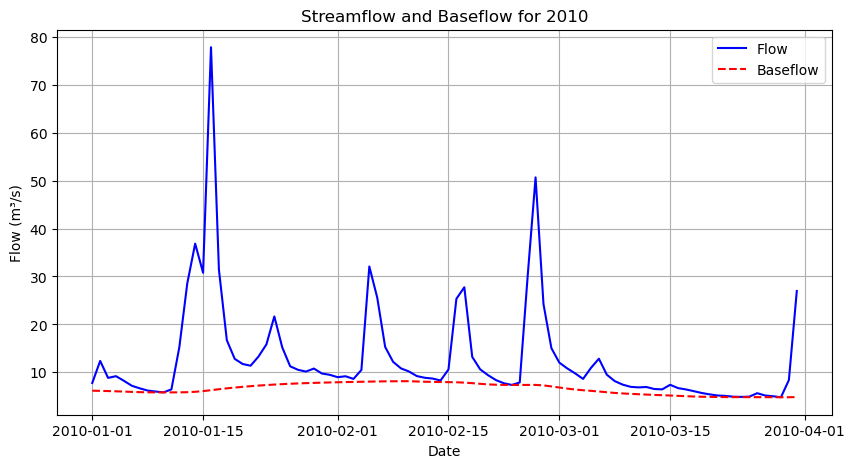

In [213]:
import matplotlib.pyplot as plt

# Let's have a look at baseflow for the first three months of 2010
year = 2010
months = [1, 2, 3]
data_year = data[(data['date'].dt.year == year) & (data['date'].dt.month.isin(months))]

plt.figure(figsize=(10, 5))
plt.plot(data_year['date'], data_year['discharge_vol'], label='Flow', color='blue')
plt.plot(data_year['date'], data_year['baseflow'], label='Baseflow', color='red', linestyle='dashed')

plt.xlabel('Date')
plt.ylabel('Flow (m³/s)')
plt.title(f'Streamflow and Baseflow for {year}')
plt.legend()
plt.grid(True)
plt.show()

# Baseflow index 
The baseflow index is a *streamflow signature* used to summarise the catchment behaviour. We can compute the baseflow index by taking the long term mean of streamflow and baseflow:

In [214]:
data = data.dropna()
data = data.groupby(['id'])[['discharge_vol', 'baseflow']].sum()
data['bfi'] = data['baseflow'] / data['discharge_vol']
data.head()

,discharge_vol,baseflow,bfi
id,,,
10002,79993.41,44614.917104,0.557732


Now, we could create a loop and calculate the baseflow index for every catchment, using a similar approach as the previous practicals. However, we needn't do this because the baseflow index is included in the CAMELS-GB metadata. Let's load the relevant file: 

In [215]:
metadata = pd.read_csv(os.path.join(DATADIR, "CAMELS_GB_hydrologic_attributes.csv"))
metadata['gauge_id'] = metadata['gauge_id'].astype(str)
metadata.head()

,gauge_id,q_mean,runoff_ratio,stream_elas,slope_fdc,baseflow_index,baseflow_index_ceh,hfd_mean,Q5,Q95,high_q_freq,high_q_dur,low_q_freq,low_q_dur,zero_q_freq
0,10002,1.30,0.57,1.36,1.94,0.67,0.63,131.33,0.31,3.48,2.17,1.35,7.41,7.52,0.0
1,10003,1.33,0.57,1.31,1.95,0.72,0.73,139.30,0.32,3.40,0.90,1.32,10.81,10.00,0.0
2,1001,1.66,0.60,1.31,4.01,0.49,0.39,110.95,0.08,5.61,6.59,1.58,103.15,11.46,0.0
3,101002,0.88,0.38,1.22,1.54,0.68,0.65,135.62,0.25,2.44,3.90,1.25,3.26,4.30,0.0
4,101005,0.80,0.35,1.28,1.47,0.62,0.59,136.79,0.25,2.29,6.23,1.44,0.42,2.80,0.0


Now let's check our estimate of baseflow index with the value included in CAMELS-GB: 

In [216]:
print(metadata[metadata['gauge_id'] == id][['gauge_id', 'baseflow_index', 'baseflow_index_ceh']])

  gauge_id  baseflow_index  baseflow_index_ceh
0    10002            0.67                0.63


There is quite a large discrepancy between our value and the value recorded in the CAMELS-GB metadata (0.56 vs 0.67, for basin id 10002). Why is this? Well, there are various ways of estimating the baseflow index and the values reported in CAMELS-GB were computed in a different way to ours.

# Further work
Using baseflow values from the metadata or those you have calculated, explore the distribution of baseflow index across the UK. To start with, you could create a boxplot showing the distribution of baseflow index.